In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import seaborn as sns

In [2]:
info_job_level_dfs = {}
info_job_level_dfs["gpu_utilization"] = pd.read_csv("job_level_gpu_utilization.csv")
info_job_level_dfs["mem_copy_utilization"] = pd.read_csv("job_level_mem_copy_utilization.csv")
info_job_level_dfs["sm_active"] = pd.read_csv("job_level_sm_active.csv")
info_job_level_dfs["tensor_active"] = pd.read_csv("job_level_tensor_active.csv")
info_job_level_dfs["fp16_active"] = pd.read_csv("job_level_fp16_active.csv")
info_job_level_dfs["fp32_active"] = pd.read_csv("job_level_fp32_active.csv")
info_job_level_dfs["fp64_active"] = pd.read_csv("job_level_fp64_active.csv")
info_job_level_dfs["fb_used"] = pd.read_csv("job_level_fb_used.csv")

gputil_all = info_job_level_dfs["gpu_utilization"]

In [3]:
temporal_gpu_level_dfs = {}

temporal_gpu_level_dfs["gpu_utilization"] = pd.read_csv("temporal_gpu_level_gpu_utilization.csv")
temporal_gpu_level_dfs["mem_copy_utilization"] = pd.read_csv("temporal_gpu_level_mem_copy_utilization.csv")
temporal_gpu_level_dfs["sm_active"] = pd.read_csv("temporal_gpu_level_sm_active.csv")
temporal_gpu_level_dfs["tensor_active"] = pd.read_csv("temporal_gpu_level_tensor_active.csv")
temporal_gpu_level_dfs["fp16_active"] = pd.read_csv("temporal_gpu_level_fp16_active.csv")
temporal_gpu_level_dfs["fp32_active"] = pd.read_csv("temporal_gpu_level_fp32_active.csv")
temporal_gpu_level_dfs["fp64_active"] = pd.read_csv("temporal_gpu_level_fp64_active.csv")
temporal_gpu_level_dfs["fb_used"] = pd.read_csv("temporal_gpu_level_fb_used.csv")

In [4]:
spatial_job_level_dfs = {}

spatial_job_level_dfs["gpu_utilization"] = pd.read_csv("spatial_job_level_gpu_utilization.csv")
spatial_job_level_dfs["mem_copy_utilization"] = pd.read_csv("spatial_job_level_mem_copy_utilization.csv")
spatial_job_level_dfs["sm_active"] = pd.read_csv("spatial_job_level_sm_active.csv")
spatial_job_level_dfs["tensor_active"] = pd.read_csv("spatial_job_level_tensor_active.csv")
spatial_job_level_dfs["fp16_active"] = pd.read_csv("spatial_job_level_fp16_active.csv")
spatial_job_level_dfs["fp32_active"] = pd.read_csv("spatial_job_level_fp32_active.csv")
spatial_job_level_dfs["fp64_active"] = pd.read_csv("spatial_job_level_fp64_active.csv")
spatial_job_level_dfs["fb_used"] = pd.read_csv("spatial_job_level_fb_used.csv")

/tmp/ipykernel_362476/994098611.py:64: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='black', alpha=1))
/tmp/ipykernel_362476/994098611.py:67: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='black', alpha=1))


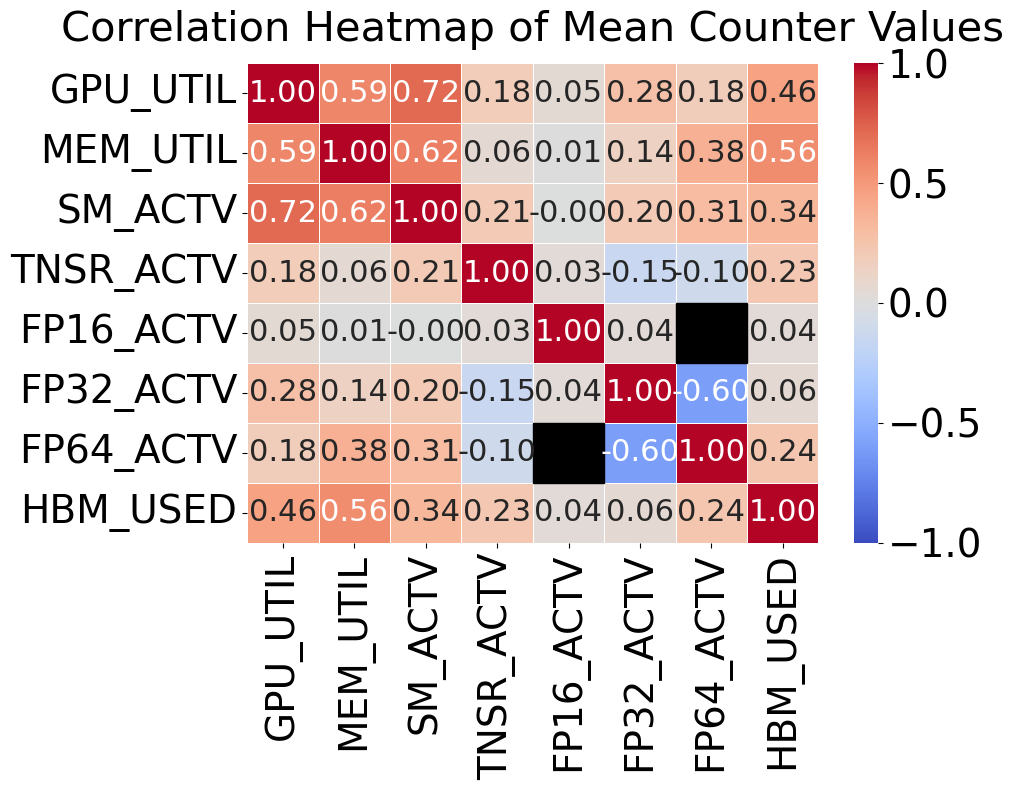

In [5]:
metrics = [
    "gpu_utilization", "mem_copy_utilization", "sm_active", 
    "tensor_active", "fp16_active", "fp32_active", "fp64_active", "fb_used"
]
merged_df = info_job_level_dfs[metrics[0]].copy()

for metric in metrics[1:]:
    merged_df = merged_df.merge(info_job_level_dfs[metric], on="jobid", suffixes=('', f'_{metric}'), how='outer')
merged_df.rename(columns={'mean_utilization':'mean_utilization_gpu_utilization'}, inplace=True)

columns_of_interest = [f"mean_utilization_{metric}" for metric in metrics]
merged_df = merged_df[columns_of_interest]

precision_columns = [
    "mean_utilization_tensor_active",
    "mean_utilization_fp16_active",
    "mean_utilization_fp32_active",
    "mean_utilization_fp64_active",
]

has_precision_usage = merged_df[precision_columns].notna().any(axis=1)

filtered_merged_df = merged_df[has_precision_usage]

removed_jobs = merged_df.shape[0] - filtered_merged_df.shape[0]

merged_df_clean = filtered_merged_df.fillna(0)
merged_df_clean = merged_df_clean[merged_df_clean["mean_utilization_gpu_utilization"] != 0]
merged_df_clean.rename(columns={'mean_utilization_gpu_utilization':'GPU_UTIL', 
                               'mean_utilization_tensor_active':'TNSR_ACTV', 
                               'mean_utilization_fp16_active':'FP16_ACTV', 
                               'mean_utilization_fp32_active':'FP32_ACTV', 
                               'mean_utilization_fp64_active':'FP64_ACTV',
                               'mean_utilization_sm_active':'SM_ACTV',
                               'mean_utilization_mem_copy_utilization':'MEM_UTIL',
                               'mean_utilization_fb_used':'HBM_USED'}, inplace=True)

spearman_corr = merged_df_clean.corr(method='spearman')

          
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    spearman_corr,  
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5, 
    vmin=-1,
    vmax=1,
    annot_kws={"size": 22},
)

for text in ax.texts:
    row_idx, col_idx = text.get_position()
    row_idx, col_idx = int(row_idx), int(col_idx)
    row_label, col_label = spearman_corr.index[row_idx], spearman_corr.columns[col_idx]
    
    if (row_label == "FP16_ACTV" and col_label == "FP64_ACTV") or (row_label == "FP64_ACTV" and col_label == "FP16_ACTV"):
        text.set_text("")

for i, row_label in enumerate(spearman_corr.index):
    for j, col_label in enumerate(spearman_corr.columns):
        if row_label == "FP16_ACTV" and col_label == "FP64_ACTV":
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='black', alpha=1))
            ax.text(j + 0.5, i + 0.5, '', ha='center', va='center', color='white', fontsize=22, fontweight='bold')
        if row_label == "FP64_ACTV" and col_label == "FP16_ACTV":
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='black', alpha=1))
            ax.text(j + 0.5, i + 0.5, '', ha='center', va='center', color='white', fontsize=22, fontweight='bold')
            
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=28)

plt.title("Correlation Heatmap of Mean Counter Values", fontsize=30, pad=16)
plt.tight_layout()
plt.show()


/tmp/ipykernel_362476/2440389606.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_merged_df.rename(columns={'spatial_imbalance_gpu_utilization':'GPU_UTIL',
/tmp/ipykernel_362476/2440389606.py:59: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='white', alpha=1))
/tmp/ipykernel_362476/2440389606.py:62: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='white', alpha=1))


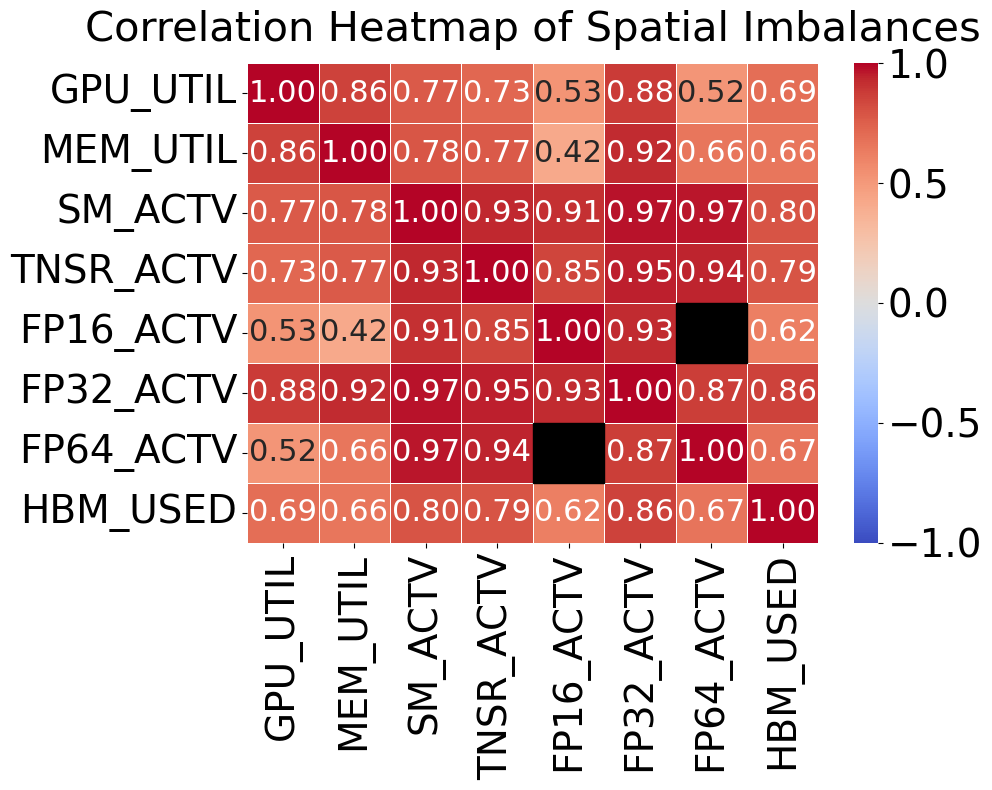

In [6]:
metrics = [
    "gpu_utilization", "mem_copy_utilization", "sm_active",
    "tensor_active", "fp16_active", "fp32_active", "fp64_active", "fb_used"
]
merged_df = spatial_job_level_dfs["gpu_utilization"].copy()

for metric in metrics[1:]:
    merged_df = merged_df.merge(spatial_job_level_dfs[metric], on="jobid", suffixes=('', f'_{metric}'), how='outer')

columns_of_interest = [f"spatial_imbalance_{metric}" for metric in metrics]
merged_df = merged_df[columns_of_interest]
merged_df = merged_df[~merged_df["spatial_imbalance_gpu_utilization"].isna()]

precision_columns = [
    "spatial_imbalance_tensor_active",
    "spatial_imbalance_fp16_active",
    "spatial_imbalance_fp32_active",
    "spatial_imbalance_fp64_active",
]

has_precision_usage = merged_df[precision_columns].notna().any(axis=1)

filtered_merged_df = merged_df[has_precision_usage]

filtered_merged_df.rename(columns={'spatial_imbalance_gpu_utilization':'GPU_UTIL', 
                               'spatial_imbalance_tensor_active':'TNSR_ACTV', 
                               'spatial_imbalance_fp16_active':'FP16_ACTV', 
                               'spatial_imbalance_fp32_active':'FP32_ACTV', 
                               'spatial_imbalance_fp64_active':'FP64_ACTV',
                               'spatial_imbalance_sm_active':'SM_ACTV',
                               'spatial_imbalance_mem_copy_utilization':'MEM_UTIL',
                               'spatial_imbalance_fb_used':'HBM_USED'}, inplace=True)

spearman_corr = filtered_merged_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    spearman_corr, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5, 
    vmin=-1,
    vmax=1,
    annot_kws={"size": 22},
)

for text in ax.texts:
    row_idx, col_idx = text.get_position()
    row_idx, col_idx = int(row_idx), int(col_idx)
    row_label, col_label = spearman_corr.index[row_idx], spearman_corr.columns[col_idx]
    
    if (row_label == "FP16_ACTV" and col_label == "FP64_ACTV") or (row_label == "FP64_ACTV" and col_label == "FP16_ACTV"):
        text.set_text("")

for i, row_label in enumerate(spearman_corr.index):
    for j, col_label in enumerate(spearman_corr.columns):
        if row_label == "FP16_ACTV" and col_label == "FP64_ACTV":
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='white', alpha=1))
            ax.text(j + 0.5, i + 0.5, '', ha='center', va='center', color='white', fontsize=22, fontweight='bold')
        if row_label == "FP64_ACTV" and col_label == "FP16_ACTV":
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='white', alpha=1))
            ax.text(j + 0.5, i + 0.5, '', ha='center', va='center', color='white', fontsize=22, fontweight='bold')

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=28)

plt.title("Correlation Heatmap of Spatial Imbalances", fontsize=30, pad=16)
plt.tight_layout()
plt.show()

/tmp/ipykernel_362476/3736448171.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_merged_df.rename(columns={'temporal_imbalance_gpu_utilization':'GPU_UTIL',
/tmp/ipykernel_362476/3736448171.py:64: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='black', alpha=1))
/tmp/ipykernel_362476/3736448171.py:67: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='black', alpha=1))


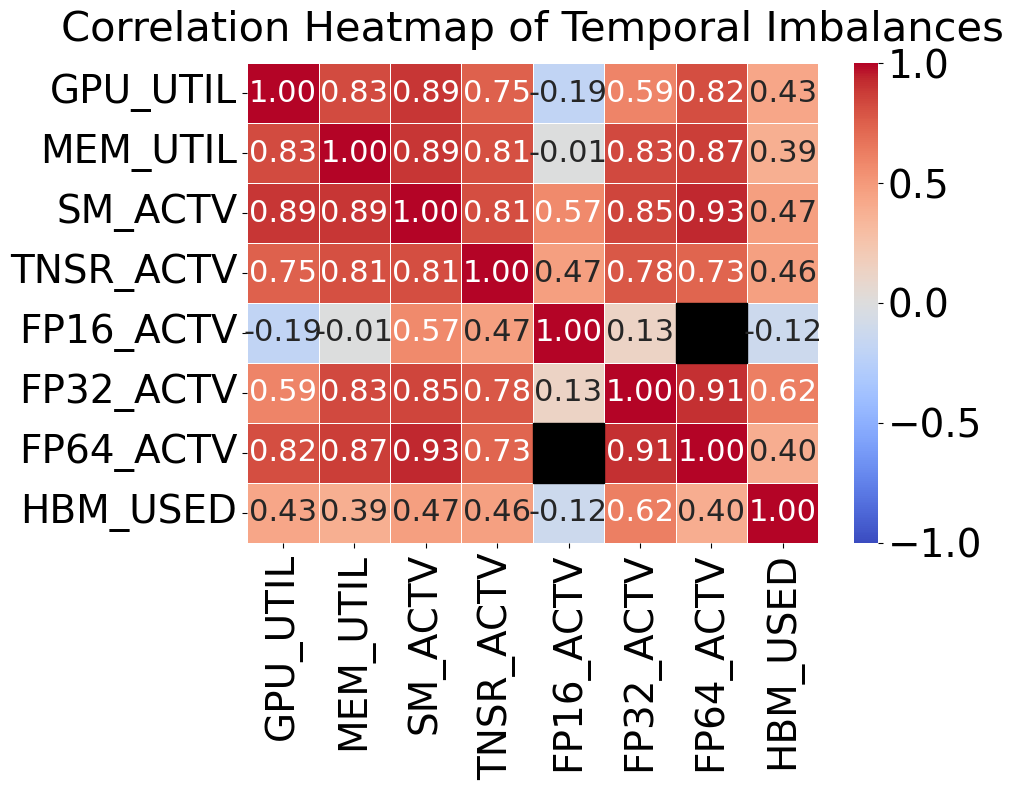

In [7]:
metrics = [
    "gpu_utilization", "mem_copy_utilization", "sm_active",
    "tensor_active", "fp16_active", "fp32_active", "fp64_active", "fb_used"
]
gputil_temporal_grouped = temporal_gpu_level_dfs["gpu_utilization"].groupby("jobid").agg({"temporal_imbalance" : 'max'}).reset_index()
merged_df = gputil_temporal_grouped.copy()

for metric in metrics[1:]:
    temporal_grouped = temporal_gpu_level_dfs[metric].groupby("jobid").agg({"temporal_imbalance" : 'max'}).reset_index()
    merged_df = merged_df.merge(temporal_grouped, on="jobid", suffixes=('', f'_{metric}'), how='outer')
merged_df
merged_df.rename(columns={'temporal_imbalance':'temporal_imbalance_gpu_utilization'}, inplace=True)

columns_of_interest = [f"temporal_imbalance_{metric}" for metric in metrics]
merged_df = merged_df[columns_of_interest]
merged_df = merged_df[~merged_df["temporal_imbalance_gpu_utilization"].isna()]


precision_columns = [
    "temporal_imbalance_tensor_active",
    "temporal_imbalance_fp16_active",
    "temporal_imbalance_fp32_active",
    "temporal_imbalance_fp64_active",
]

has_precision_usage = merged_df[precision_columns].notna().any(axis=1)

filtered_merged_df = merged_df[has_precision_usage]

filtered_merged_df.rename(columns={'temporal_imbalance_gpu_utilization':'GPU_UTIL', 
                               'temporal_imbalance_tensor_active':'TNSR_ACTV', 
                               'temporal_imbalance_fp16_active':'FP16_ACTV', 
                               'temporal_imbalance_fp32_active':'FP32_ACTV', 
                               'temporal_imbalance_fp64_active':'FP64_ACTV',
                               'temporal_imbalance_sm_active':'SM_ACTV',
                               'temporal_imbalance_mem_copy_utilization':'MEM_UTIL',
                               'temporal_imbalance_fb_used':'HBM_USED'}, inplace=True)

spearman_corr = filtered_merged_df.corr(method='spearman')

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    spearman_corr, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5, 
    vmin=-1, 
    vmax=1, 
    annot_kws={"size": 22},
)

for text in ax.texts:
    row_idx, col_idx = text.get_position()
    row_idx, col_idx = int(row_idx), int(col_idx)
    row_label, col_label = spearman_corr.index[row_idx], spearman_corr.columns[col_idx]
    
    if (row_label == "FP16_ACTV" and col_label == "FP64_ACTV") or (row_label == "FP64_ACTV" and col_label == "FP16_ACTV"):
        text.set_text("")

for i, row_label in enumerate(spearman_corr.index):
    for j, col_label in enumerate(spearman_corr.columns):
        if row_label == "FP16_ACTV" and col_label == "FP64_ACTV":
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='black', alpha=1))
            ax.text(j + 0.5, i + 0.5, '', ha='center', va='center', color='white', fontsize=22, fontweight='bold')
        if row_label == "FP64_ACTV" and col_label == "FP16_ACTV":
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='black', alpha=1))
            ax.text(j + 0.5, i + 0.5, '', ha='center', va='center', color='white', fontsize=22, fontweight='bold')

plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=28)

plt.title("Correlation Heatmap of Temporal Imbalances", fontsize=30, pad=16)
plt.tight_layout()
plt.show()